✅ Data loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11498701 entries, 0 to 11498700
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1),

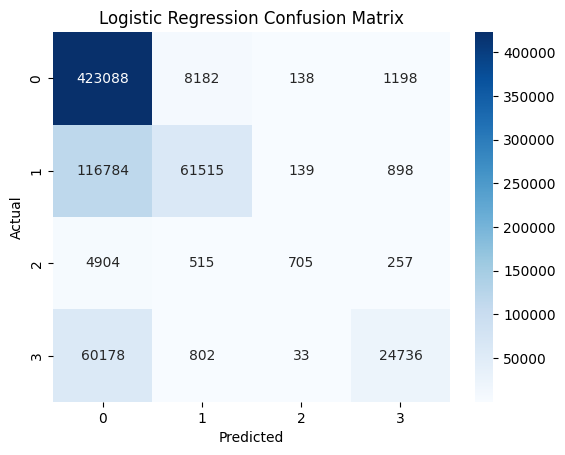


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.99      0.81    432606
           1       0.90      0.29      0.44    179336
           2       0.00      0.00      0.00      6381
           3       0.93      0.26      0.41     85749

    accuracy                           0.71    704072
   macro avg       0.63      0.38      0.41    704072
weighted avg       0.77      0.71      0.66    704072



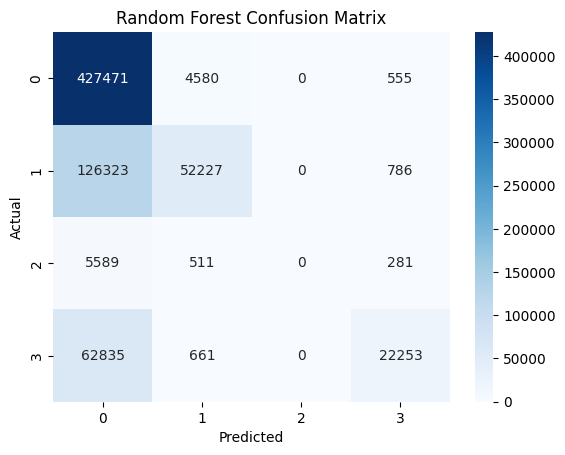


Linear SVM Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.98      0.82    432606
           1       0.87      0.34      0.49    179336
           2       0.78      0.07      0.14      6381
           3       0.91      0.29      0.44     85749

    accuracy                           0.72    704072
   macro avg       0.81      0.42      0.47    704072
weighted avg       0.77      0.72      0.68    704072



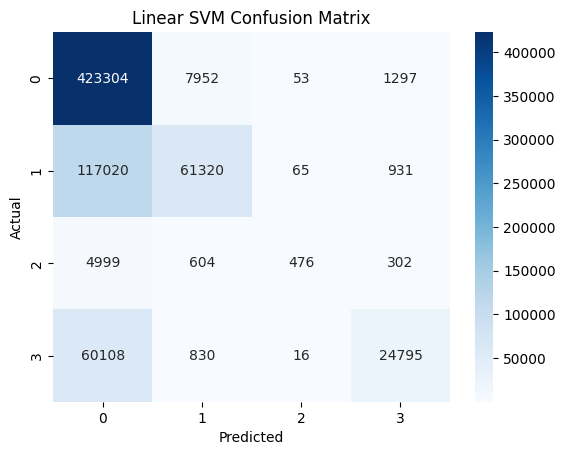


🔍 Predicted category: Credit reporting, repair, or other


In [1]:
# =============================================
# 1. Import Required Libraries
# =============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC   # much faster than SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
import re
import multiprocessing
warnings.filterwarnings('ignore')

# =============================================
# 2. Load the data
# =============================================
DATA_PATH = r'D:\Kaibur\Kaiburr\task 5\complaints.csv'
df = pd.read_csv(DATA_PATH)
print("✅ Data loaded successfully!")
print(df.info())

# =============================================
# 3. Filter relevant categories
# =============================================
category_map = {
    'Credit reporting, credit repair services, or other personal consumer reports': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}
df = df[df['Product'].isin(category_map.keys())]
df['target'] = df['Product'].map(category_map)

# =============================================
# 4. Detect the complaint text column
# =============================================
complaint_col = None
for col in df.columns:
    if col.lower().strip() in ['consumer complaint', 'consumer complaint narrative']:
        complaint_col = col
        break
if complaint_col is None:
    raise KeyError("Complaint text column not found. Please check your CSV column names.")

# =============================================
# 5. Fast text preprocessing using vectorized str ops
# =============================================
df['clean_complaint'] = (
    df[complaint_col]
    .astype(str)
    .str.lower()
    .str.replace(r'[^a-z0-9 ]', '', regex=True)
)

# =============================================
# 6. Vectorization (limit features for speed)
# =============================================
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))  # fewer features + bigrams
X = vectorizer.fit_transform(df['clean_complaint'])
y = df['target']

# =============================================
# 7. Train/Test Split
# =============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =============================================
# 8. Models (optimized)
# =============================================
models = {
    'Logistic Regression': LogisticRegression(max_iter=300, n_jobs=-1, solver='saga'),
    'Random Forest': RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=20),
    'Linear SVM': LinearSVC()
}

# =============================================
# 9. Training and Evaluation
# =============================================
results = {}
for name, model in models.items():
    print(f"\n🚀 Training {name} ...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

# =============================================
# 10. Visualization & Reports
# =============================================
for name, model in models.items():
    print(f"\n{name} Classification Report:")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# =============================================
# 11. Example Prediction
# =============================================
sample_text = "I am unable to resolve my credit report issue despite multiple attempts."
sample_clean = re.sub(r'[^a-z0-9 ]', '', sample_text.lower())
sample_vec = vectorizer.transform([sample_clean])
pred = models['Logistic Regression'].predict(sample_vec)[0]
category_names = ['Credit reporting, repair, or other', 'Debt collection', 'Consumer Loan', 'Mortgage']
print(f"\n🔍 Predicted category: {category_names[pred]}")
